#### 00. IMPORT DE PACOTES E FUNÇÕES ÚTEIS

- Módulos criados para o projeto também são carregados

In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn import model_selection
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from feature_engine.encoding import OneHotEncoder
from feature_engine import discretisation

from lightgbm import LGBMClassifier

pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)

from pipeline.preprocess import *
from pipeline.utils import *
from pipeline.carregar_dados import *
from pipeline.criar_abt import *

from features.features_clientes import *
from features.features_quantidade import *
from features.features_valor import *
from features.features_tempo import *
from features.features_flags import *
from features.features_clientes_transacional import *

#### 01. CARREGAR DADOS ORIGINAIS COM PRÉ-PROCESSAMENTO MÍNIMO

In [2]:
dados = carregar_dados()

df_clientes = dados['clientes']
df_inadimplencia = dados['inadimplencia']
df_transacoes = dados['transacoes']

clientes_prep = preprocessar_clientes(df_clientes)
inad_prep = preprocessar_inadimplencia(df_inadimplencia)
tran_prep = preprocessar_transacoes(df_transacoes)

inad_prep = inad_prep.dropna(subset=["atraso_90d"]).copy()

print("Clientes:", clientes_prep.shape)
print("Inadimplência:", inad_prep.shape)
print("Transações:", tran_prep.shape)

Clientes: (200, 10)
Inadimplência: (4790, 4)
Transações: (2000, 4)


#### 02. GERAÇÃO DA ABT 

- Merge com as bases de features criadas.

- Cada unidade experimental corresponderá ao par *id_cliente* + *data_referencia*, e as variáveis corresponderão a essa referência.

- A base que será utilizada durante todo o desenvolvimento teve os cálculos de suas features baseados numa janela de observação M-1, garantindo assim que não utilize dados do mesmo mês a que a coluna *mes_safra* da base de inadimplência se refere.

- Como será observado adiante, a taxa de inadimplência tem valor de 10%, o que pode gerar alguns problemas durante a modelagem devido ao desbalanceamento.

In [3]:
abt = gerar_abt(clientes_prep, 
                inad_prep, 
                tran_prep, 
                usar_M_1=True)

print("Shape M-1:", abt.shape)

Shape M-1: (4790, 99)


In [4]:
abt_M = gerar_abt(clientes_prep,
                  inad_prep,
                  tran_prep,
                  usar_M_1=False)

print("Shape M:", abt_M.shape)

Shape M: (4790, 99)


In [5]:
abt.head(10)

,id_cliente,mes_safra,data_referencia,atraso_90d,idade,renda_mensal,data_abertura_conta,mes_abertura_conta,estado_civil,tempo_emprego_anos,qtde_produtos,score_interno,limite_credito,idade2,log_renda,renda_por_limite,multi_produto_flag,vlr_trans_1m,vlr_trans_3m,vlr_trans_6m,vlr_trans_9m,vlr_trans_12m,vlr_trans_24m,vlr_trans_ever,vlr_trans_ult,vlr_trans_max,vlr_trans_min,comp_vlr_1m_vs_3m,delta_vlr_1m_vs_3m,comp_vlr_3m_vs_6m,delta_vlr_3m_vs_6m,comp_vlr_6m_vs_9m,delta_vlr_6m_vs_9m,comp_vlr_9m_vs_12m,delta_vlr_9m_vs_12m,comp_vlr_12m_vs_24m,delta_vlr_12m_vs_24m,comp_vlr_24m_vs_ever,delta_vlr_24m_vs_ever,qtde_trans_1m,qtde_trans_3m,qtde_trans_6m,qtde_trans_9m,qtde_trans_12m,qtde_trans_24m,qtde_trans_ever,pct_qtde_trans_1m,pct_qtde_trans_3m,pct_qtde_trans_6m,pct_qtde_trans_12m,pct_qtde_trans_24m,comp_qtde_1m_vs_3m,delta_qtde_1m_vs_3m,comp_qtde_3m_vs_6m,delta_qtde_3m_vs_6m,comp_qtde_6m_vs_9m,delta_qtde_6m_vs_9m,comp_qtde_9m_vs_12m,delta_qtde_9m_vs_12m,comp_qtde_12m_vs_24m,delta_qtde_12m_vs_24m,comp_qtde_24m_vs_ever,delta_qtde_24m_vs_ever,tempo_desde_primeira_1m,tempo_desde_ultima_1m,tempo_desde_primeira_3m,tempo_desde_ultima_3m,tempo_desde_primeira_6m,tempo_desde_ultima_6m,tempo_desde_primeira_9m,tempo_desde_ultima_9m,tempo_desde_primeira_12m,tempo_desde_ultima_12m,tempo_desde_primeira_24m,tempo_desde_ultima_24m,tempo_desde_primeira_ever,tempo_desde_ultima_ever,flag_nunca_transacionou,flag_transacao_1m,flag_transacao_3m,flag_transacao_6m,flag_transacao_9m,flag_transacao_12m,flag_transacao_24m,flag_transacao_ever,tempo_relacionamento_anos,tempo_relacionamento_meses,tempo_relacionamento_isna,flag_cliente_antigo,flag_cliente_antigo_isna,idade_relativa,limite_por_ano_conta,limite_por_ano_conta_isna,limite_por_mes_conta,limite_por_mes_conta_isna,produtos_por_ano_conta,produtos_por_ano_conta_isna,produtos_por_mes_conta,produtos_por_mes_conta_isna
0,C0001,2023-09,2023-09-30,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7139,20.5650,0,0.0,0,54.2861,13439.523893,0,1120.058352,0,2.917323,0,0.243132,0
1,C0001,2023-10,2023-10-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7960,21.5506,0,0.0,0,54.2040,12825.167038,0,1068.833350,0,2.783964,0,0.232012,0
2,C0001,2023-11,2023-11-30,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8809,22.5690,0,0.0,0,54.1191,12246.265086,0,1020.603483,0,2.658302,0,0.221543,0
3,C0001,2023-12,2023-12-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9630,23.5545,0,0.0,0,54.0370,11734.080489,0,977.902312,0,2.547122,0,0.212274,0
4,C0001,2024-01,2024-01-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,

In [6]:
abt_M.head(10)

,id_cliente,mes_safra,data_referencia,atraso_90d,idade,renda_mensal,data_abertura_conta,mes_abertura_conta,estado_civil,tempo_emprego_anos,qtde_produtos,score_interno,limite_credito,idade2,log_renda,renda_por_limite,multi_produto_flag,vlr_trans_1m,vlr_trans_3m,vlr_trans_6m,vlr_trans_9m,vlr_trans_12m,vlr_trans_24m,vlr_trans_ever,vlr_trans_ult,vlr_trans_max,vlr_trans_min,comp_vlr_1m_vs_3m,delta_vlr_1m_vs_3m,comp_vlr_3m_vs_6m,delta_vlr_3m_vs_6m,comp_vlr_6m_vs_9m,delta_vlr_6m_vs_9m,comp_vlr_9m_vs_12m,delta_vlr_9m_vs_12m,comp_vlr_12m_vs_24m,delta_vlr_12m_vs_24m,comp_vlr_24m_vs_ever,delta_vlr_24m_vs_ever,qtde_trans_1m,qtde_trans_3m,qtde_trans_6m,qtde_trans_9m,qtde_trans_12m,qtde_trans_24m,qtde_trans_ever,pct_qtde_trans_1m,pct_qtde_trans_3m,pct_qtde_trans_6m,pct_qtde_trans_12m,pct_qtde_trans_24m,comp_qtde_1m_vs_3m,delta_qtde_1m_vs_3m,comp_qtde_3m_vs_6m,delta_qtde_3m_vs_6m,comp_qtde_6m_vs_9m,delta_qtde_6m_vs_9m,comp_qtde_9m_vs_12m,delta_qtde_9m_vs_12m,comp_qtde_12m_vs_24m,delta_qtde_12m_vs_24m,comp_qtde_24m_vs_ever,delta_qtde_24m_vs_ever,tempo_desde_primeira_1m,tempo_desde_ultima_1m,tempo_desde_primeira_3m,tempo_desde_ultima_3m,tempo_desde_primeira_6m,tempo_desde_ultima_6m,tempo_desde_primeira_9m,tempo_desde_ultima_9m,tempo_desde_primeira_12m,tempo_desde_ultima_12m,tempo_desde_primeira_24m,tempo_desde_ultima_24m,tempo_desde_primeira_ever,tempo_desde_ultima_ever,flag_nunca_transacionou,flag_transacao_1m,flag_transacao_3m,flag_transacao_6m,flag_transacao_9m,flag_transacao_12m,flag_transacao_24m,flag_transacao_ever,tempo_relacionamento_anos,tempo_relacionamento_meses,tempo_relacionamento_isna,flag_cliente_antigo,flag_cliente_antigo_isna,idade_relativa,limite_por_ano_conta,limite_por_ano_conta_isna,limite_por_mes_conta,limite_por_mes_conta_isna,produtos_por_ano_conta,produtos_por_ano_conta_isna,produtos_por_mes_conta,produtos_por_mes_conta_isna
0,C0001,2023-09,2023-09-30,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7960,21.5506,0,0.0,0,54.2040,12825.167038,0,1068.833350,0,2.783964,0,0.232012,0
1,C0001,2023-10,2023-10-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8809,22.5690,0,0.0,0,54.1191,12246.265086,0,1020.603483,0,2.658302,0,0.221543,0
2,C0001,2023-11,2023-11-30,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9630,23.5545,0,0.0,0,54.0370,11734.080489,0,977.902312,0,2.547122,0,0.212274,0
3,C0001,2023-12,2023-12-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0479,24.5729,0,0.0,0,53.9521,11247.619513,0,937.374099,0,2.441525,0,0.203476,0
4,C0001,2024-01,2024-01-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,

##### COMPARAÇÃO ENTRE CONCEITOS M-1 E M COM A JANELA DESLOCADA EM 1 MÊS. 

- NO EXEMPLO, AS VARIÁVEIS `vlr_trans_3m` E `qtde_trans_3m`

In [7]:
pd.concat([abt.loc[abt['id_cliente'] == 'C0001',['id_cliente','mes_safra','data_referencia', 'vlr_trans_3m']].head(20), 
           abt_M.loc[abt_M['id_cliente'] == 'C0001',['vlr_trans_3m']].head(20),
           abt.loc[abt['id_cliente'] == 'C0001',['qtde_trans_3m']].head(20),
           abt_M.loc[abt_M['id_cliente'] == 'C0001',['qtde_trans_3m']].head(20)],
           axis=1)

,id_cliente,mes_safra,data_referencia,vlr_trans_3m,vlr_trans_3m,qtde_trans_3m,qtde_trans_3m
0,C0001,2023-09,2023-09-30,0.00,0.00,0,0
1,C0001,2023-10,2023-10-31,0.00,0.00,0,0
2,C0001,2023-11,2023-11-30,0.00,0.00,0,0
3,C0001,2023-12,2023-12-31,0.00,0.00,0,0
4,C0001,2024-01,2024-01-31,0.00,0.00,0,0
5,C0001,2024-02,2024-02-29,0.00,0.00,0,0
6,C0001,2024-03,2024-03-31,0.00,6239.65,0,2
7,C0001,2024-04,2024-04-30,6239.65,10805.73,2,3
8,C0001,2024-05,2024-05-31,10805.73,10805.73,3,3
9,C0001,2024-06,2024-06-30,10805.73,4566.08,3,1


In [8]:
abt.isna().mean().sort_values(ascending=False)

tempo_desde_ultima_1m          0.716075
tempo_desde_primeira_1m        0.716075
comp_vlr_1m_vs_3m              0.498330
comp_qtde_1m_vs_3m             0.497912
tempo_desde_ultima_3m          0.497912
tempo_desde_primeira_3m        0.497912
comp_qtde_3m_vs_6m             0.354071
tempo_desde_primeira_6m        0.354071
tempo_desde_ultima_6m          0.354071
comp_vlr_3m_vs_6m              0.354071
tempo_desde_ultima_9m          0.252610
tempo_desde_primeira_9m        0.252610
comp_qtde_6m_vs_9m             0.252610
comp_vlr_6m_vs_9m              0.252610
vlr_trans_ult                  0.243633
tempo_desde_primeira_12m       0.239875
comp_vlr_9m_vs_12m             0.239875
comp_qtde_9m_vs_12m            0.239875
tempo_desde_ultima_12m         0.239875
comp_vlr_24m_vs_ever           0.239040
comp_vlr_12m_vs_24m            0.239040
vlr_trans_min                  0.239040
vlr_trans_max                  0.239040
pct_qtde_trans_24m             0.239040
pct_qtde_trans_12m             0.239040


#### QUAL A INADIMPLÊNCIA TOTAL DA BASE DE DADOS? E AO LONGO DAS SAFRAS?

,atraso_90d,Qtd.,Pct.%
0,0.0,4306,89.9
1,1.0,484,10.1


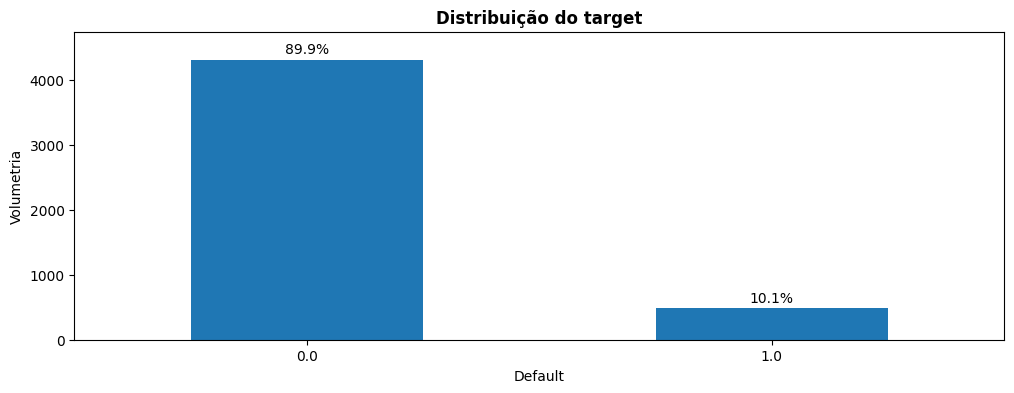

In [10]:
plot_categ(abt, 'atraso_90d', titulo='Distribuição do target', xlabel='Default',ylabel='Volumetria')

In [ ]:
def plot_txmau_categ(df, column, column_mau, mau=1): # usando mau = 1 
    df2 = df[[column, column_mau]].copy() 
    df2['mau'] = [1 if x == mau else 0 for x in df2[column_mau]] 
    
    aux = df2.groupby(column)["mau"].agg(["mean", 'count']) 
    aux = aux.rename(columns={'mean': 'Tx. default', 'count': 'Volumetria'}) 
    aux.plot.bar(rot=45, subplots=True, figsize=(12, 4), fontsize=8) 
    
    
    return aux

,Tx. default,Volumetria
mes_safra,,
2023-09,0.090909,198
2023-10,0.100000,200
2023-11,0.125000,200
2023-12,0.095000,200
2024-01,0.075000,200
2024-02,0.115578,199
2024-03,0.085000,200
2024-04,0.095477,199
2024-05,0.125000,200


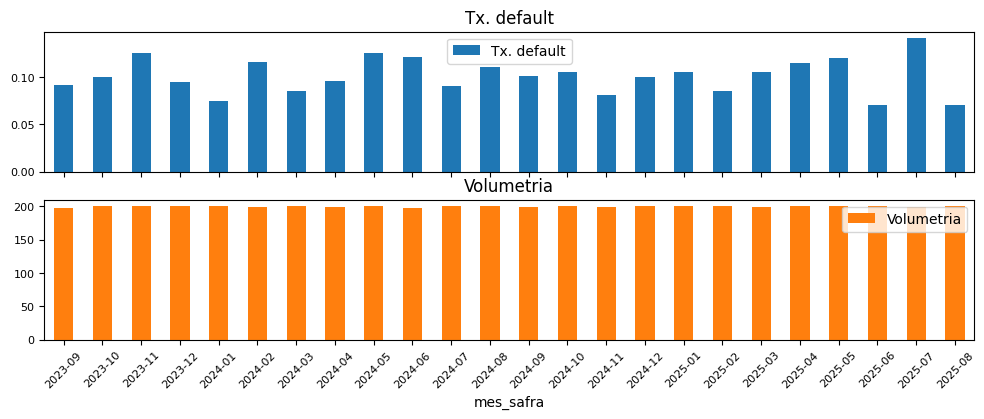

In [32]:
plot_txmau_categ(abt, column='mes_safra', column_mau='atraso_90d')

#### QUAL A INADIMPLÊNCIA POR CLIENTE?

In [18]:
mau = 1
df2 =abt[['id_cliente', 'atraso_90d']].copy()
df2['mau'] = [1 if x == mau else 0 for x in df2['atraso_90d']]
aux = df2.groupby('id_cliente')["mau"].agg(["mean", 'count']
                                          )
aux = aux.rename(columns={'mean' : 'tx_mau', 'count' : 'N'}).sort_values('tx_mau', ascending=False)
aux.head(20)

,tx_mau,N
id_cliente,,
C0030,0.291667,24
C0061,0.250000,24
C0163,0.250000,24
C0169,0.250000,24
C0031,0.208333,24
C0048,0.208333,24
C0006,0.208333,24
C0040,0.208333,24
C0185,0.208333,24


#### QUAL A INADIMPLÊNCIA OBSERVADA EM VARIÁVEL?

- OBS: PARA VARIÁVEIS NUMÉRICAS - CATEGORIZAÇÃO POR QUANTIS

,Tx. default,Volumetria
estado_civil,,
divorciado,0.084650,886
nan,0.097222,792
viuvo,0.099164,837
solteiro,0.106646,1294
casado,0.113150,981


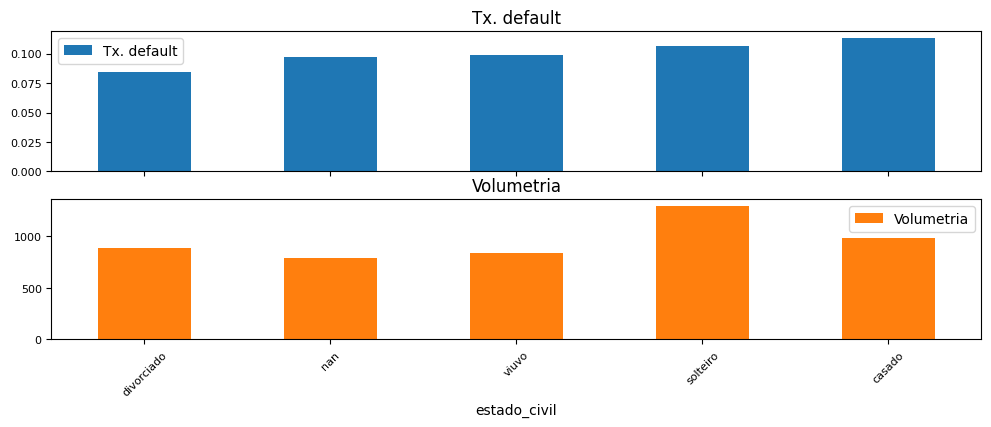

In [ ]:
plot_txmau_categ(abt, "estado_civil", "atraso_90d", sort_by="Tx. default", ascending=True)


,Tx. default,Volumetria
estado_civil,,
casado,0.113150,981
divorciado,0.084650,886
nan,0.097222,792
solteiro,0.106646,1294
viuvo,0.099164,837


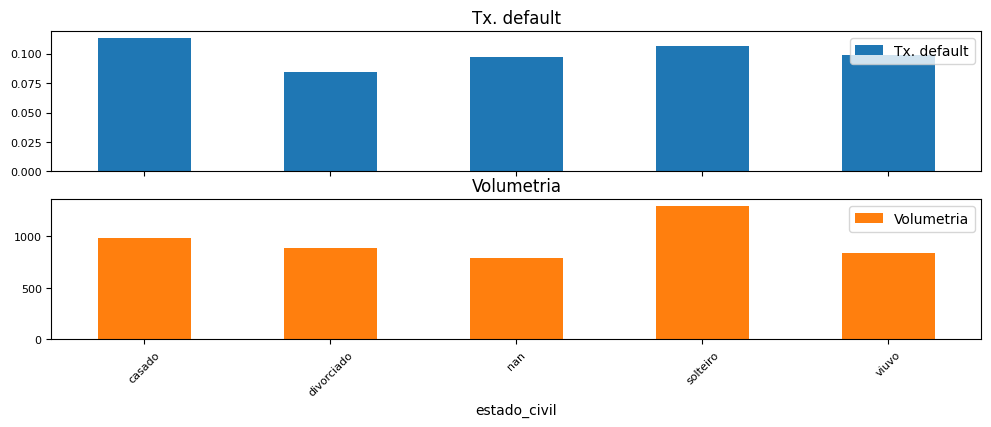

In [57]:
plot_txmau_categ(abt, column='estado_civil', column_mau='atraso_90d')

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:457: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


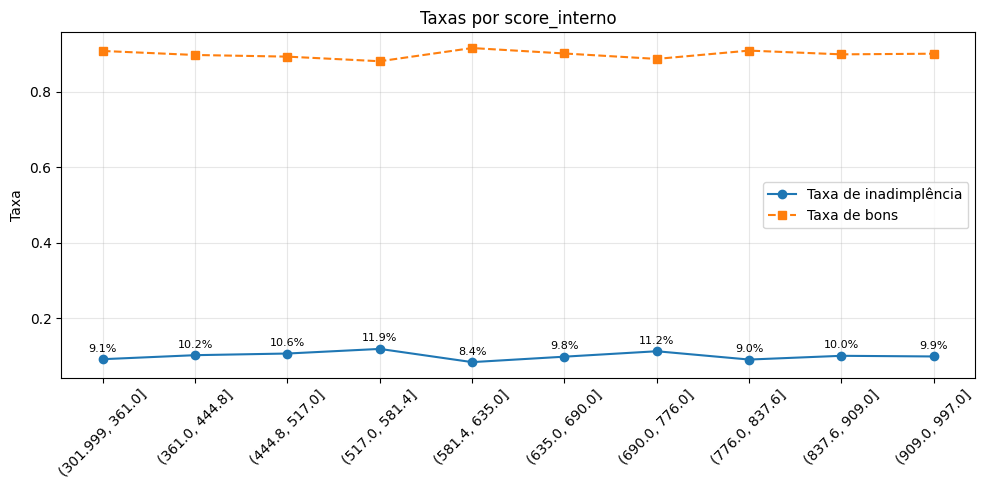

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(301.999, 361.0]",503,457,46,0.091451
1,"(361.0, 444.8]",431,387,44,0.102088
2,"(444.8, 517.0]",479,428,51,0.106472
3,"(517.0, 581.4]",455,401,54,0.118681
4,"(581.4, 635.0]",478,438,40,0.083682
5,"(635.0, 690.0]",479,432,47,0.098121
6,"(690.0, 776.0]",480,426,54,0.112500
7,"(776.0, 837.6]",431,392,39,0.090487
8,"(837.6, 909.0]",478,430,48,0.100418
9,"(909.0, 997.0]",456,411,45,0.098684


In [58]:
plot_inad_var(abt, "score_interno", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:432: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


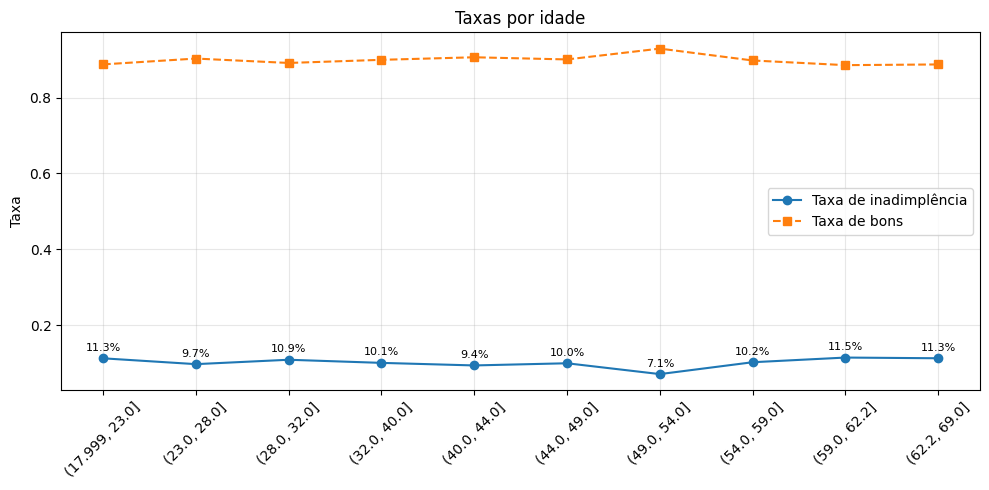

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(17.999, 23.0]",524,465,59,0.112595
1,"(23.0, 28.0]",504,455,49,0.097222
2,"(28.0, 32.0]",432,385,47,0.108796
3,"(32.0, 40.0]",527,474,53,0.100569
4,"(40.0, 44.0]",501,454,47,0.093812
5,"(44.0, 49.0]",432,389,43,0.099537
6,"(49.0, 54.0]",479,445,34,0.070981
7,"(54.0, 59.0]",528,474,54,0.102273
8,"(59.0, 62.2]",384,340,44,0.114583
9,"(62.2, 69.0]",479,425,54,0.112735


In [99]:
plot_inad_var(abt, "idade", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:432: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


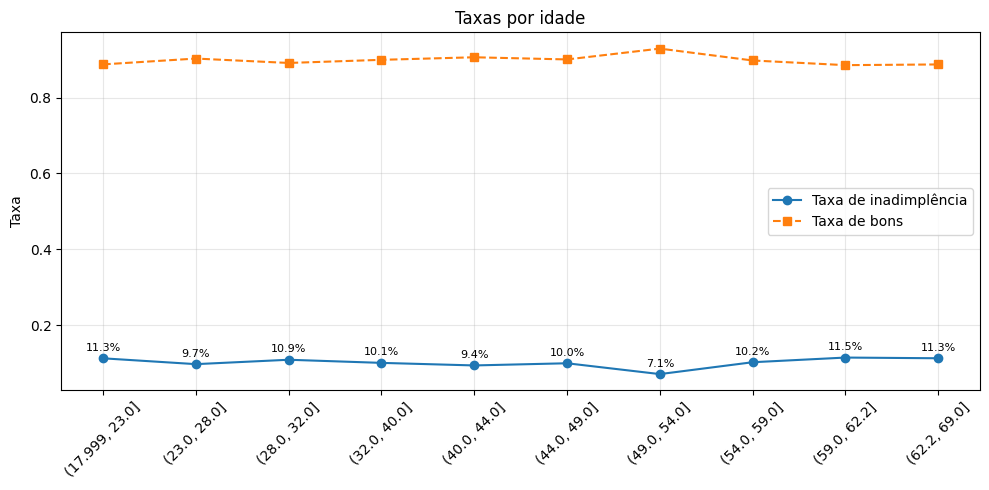

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(17.999, 23.0]",524,465,59,0.112595
1,"(23.0, 28.0]",504,455,49,0.097222
2,"(28.0, 32.0]",432,385,47,0.108796
3,"(32.0, 40.0]",527,474,53,0.100569
4,"(40.0, 44.0]",501,454,47,0.093812
5,"(44.0, 49.0]",432,389,43,0.099537
6,"(49.0, 54.0]",479,445,34,0.070981
7,"(54.0, 59.0]",528,474,54,0.102273
8,"(59.0, 62.2]",384,340,44,0.114583
9,"(62.2, 69.0]",479,425,54,0.112735


In [100]:
plot_inad_var(abt, "idade", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:432: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


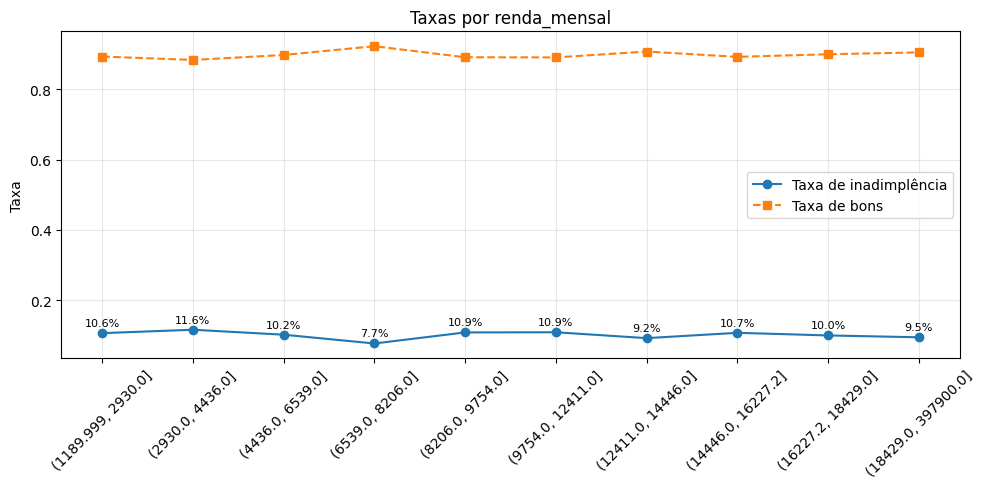

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(1189.999, 2930.0]",479,428,51,0.106472
1,"(2930.0, 4436.0]",456,403,53,0.116228
2,"(4436.0, 6539.0]",480,431,49,0.102083
3,"(6539.0, 8206.0]",454,419,35,0.077093
4,"(8206.0, 9754.0]",479,427,52,0.108559
5,"(9754.0, 12411.0]",477,425,52,0.109015
6,"(12411.0, 14446.0]",455,413,42,0.092308
7,"(14446.0, 16227.2]",456,407,49,0.107456
8,"(16227.2, 18429.0]",480,432,48,0.100000
9,"(18429.0, 397900.0]",454,411,43,0.094714


In [101]:
plot_inad_var(abt, "renda_mensal", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:432: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


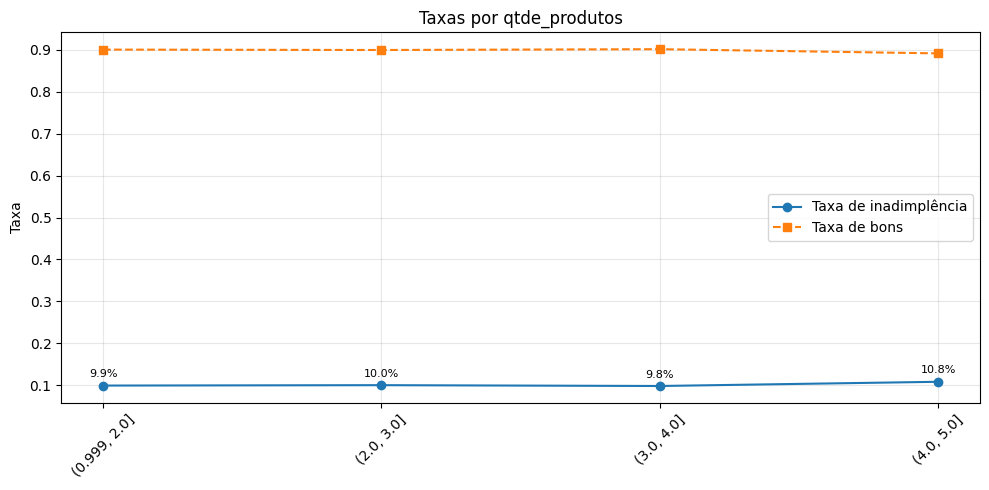

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(0.999, 2.0]",1987,1790,197,0.099144
1,"(2.0, 3.0]",1079,971,108,0.100093
2,"(3.0, 4.0]",744,671,73,0.098118
3,"(4.0, 5.0]",980,874,106,0.108163


In [102]:
plot_inad_var(abt, "qtde_produtos", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:457: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


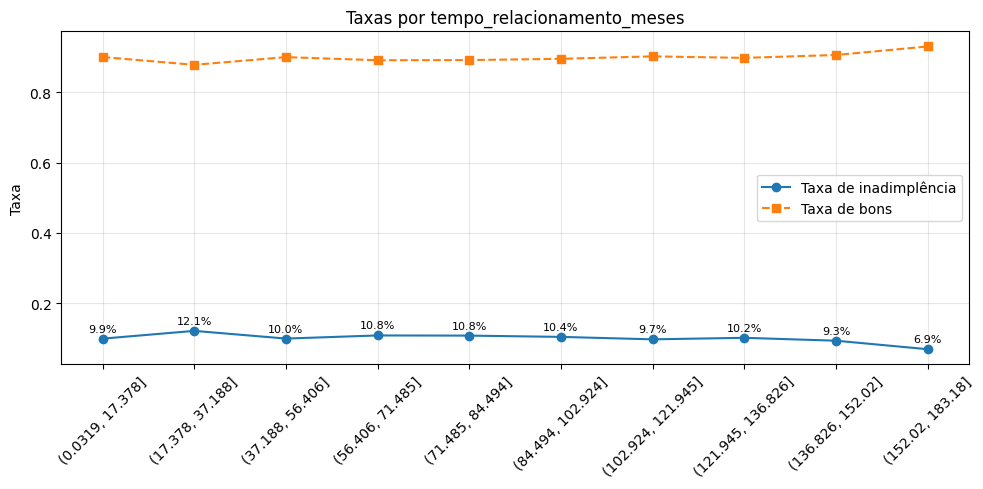

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(0.0319, 17.378]",463,417,46,0.099352
1,"(17.378, 37.188]",461,405,56,0.121475
2,"(37.188, 56.406]",462,416,46,0.099567
3,"(56.406, 71.485]",461,411,50,0.108460
4,"(71.485, 84.494]",463,413,50,0.107991
5,"(84.494, 102.924]",460,412,48,0.104348
6,"(102.924, 121.945]",462,417,45,0.097403
7,"(121.945, 136.826]",462,415,47,0.101732
8,"(136.826, 152.02]",460,417,43,0.093478
9,"(152.02, 183.18]",462,430,32,0.069264


In [41]:
plot_inad_var(abt, "tempo_relacionamento_meses", target="atraso_90d", bins=10)

In [39]:
corr = abt.drop(columns=['id_cliente', 'data_referencia', 'data_abertura_conta', 'mes_abertura_conta','mes_safra', 'estado_civil']).corr(method = 'pearson')
corr

,atraso_90d,idade,renda_mensal,tempo_emprego_anos,qtde_produtos,score_interno,limite_credito,idade2,log_renda,renda_por_limite,multi_produto_flag,vlr_trans_1m,vlr_trans_3m,vlr_trans_6m,vlr_trans_9m,vlr_trans_12m,vlr_trans_24m,vlr_trans_ever,vlr_trans_ult,vlr_trans_max,vlr_trans_min,comp_vlr_1m_vs_3m,delta_vlr_1m_vs_3m,comp_vlr_3m_vs_6m,delta_vlr_3m_vs_6m,comp_vlr_6m_vs_9m,delta_vlr_6m_vs_9m,comp_vlr_9m_vs_12m,delta_vlr_9m_vs_12m,comp_vlr_12m_vs_24m,delta_vlr_12m_vs_24m,comp_vlr_24m_vs_ever,delta_vlr_24m_vs_ever,qtde_trans_1m,qtde_trans_3m,qtde_trans_6m,qtde_trans_9m,qtde_trans_12m,qtde_trans_24m,qtde_trans_ever,pct_qtde_trans_1m,pct_qtde_trans_3m,pct_qtde_trans_6m,pct_qtde_trans_12m,pct_qtde_trans_24m,comp_qtde_1m_vs_3m,delta_qtde_1m_vs_3m,comp_qtde_3m_vs_6m,delta_qtde_3m_vs_6m,comp_qtde_6m_vs_9m,delta_qtde_6m_vs_9m,comp_qtde_9m_vs_12m,delta_qtde_9m_vs_12m,comp_qtde_12m_vs_24m,delta_qtde_12m_vs_24m,comp_qtde_24m_vs_ever,delta_qtde_24m_vs_ever,tempo_desde_primeira_1m,tempo_desde_ultima_1m,tempo_desde_primeira_3m,tempo_desde_ultima_3m,tempo_desde_primeira_6m,tempo_desde_ultima_6m,tempo_desde_primeira_9m,tempo_desde_ultima_9m,tempo_desde_primeira_12m,tempo_desde_ultima_12m,tempo_desde_primeira_24m,tempo_desde_ultima_24m,tempo_desde_primeira_ever,tempo_desde_ultima_ever,flag_nunca_transacionou,flag_transacao_1m,flag_transacao_3m,flag_transacao_6m,flag_transacao_9m,flag_transacao_12m,flag_transacao_24m,flag_transacao_ever,tempo_relacionamento_anos,tempo_relacionamento_meses,tempo_relacionamento_isna,flag_cliente_antigo,flag_cliente_antigo_isna,idade_relativa,limite_por_ano_conta,limite_por_ano_conta_isna,limite_por_mes_conta,limite_por_mes_conta_isna,produtos_por_ano_conta,produtos_por_ano_conta_isna,produtos_por_mes_conta,produtos_por_mes_conta_isna
atraso_90d,1.000000,-0.001176,0.013887,-0.004671,0.009955,-0.001030,-0.006314,0.003334,-0.003168,0.000631,0.008141,-0.009280,-0.017400,-0.013979,-0.020901,-0.023522,-0.022767,-0.022767,-0.021701,-0.031067,-0.018863,-0.012047,0.015085,-0.022558,0.002777,-0.007227,0.017279,-0.011320,0.011475,0.002452,0.003248,NaN,NaN,0.006337,0.005858,0.013310,0.010216,0.013921,0.007768,0.007768,-0.002707,-0.009865,-0.006902,0.006026,NaN,-0.002729,-0.003709,-0.014355,-0.015807,-0.006497,0.000296,-0.010915,-0.014124,0.006033,0.009274,NaN,NaN,-0.029061,-0.014143,0.000703,-0.007498,0.027238,-0.002930,0.009950,-0.004036,0.012472,-0.007453,0.004582,-0.008829,0.004582,-0.008829,0.003743,0.012156,0.002910,0.003381,0.010531,0.011074,NaN,NaN,-0.029998,-0.029998,0.012656,-0.022643,0.012656,0.002853,-0.008797,0.012656,-0.008835,0.012656,-0.008603,0.012656,-0.008640,0.012656
idade,-0.001176,1.000000,0.101102,0.054197,0.089344,-0.140360,0.047062,0.987813,0.041040,0.003031,0.036575,-0.003077,-0.005223,-0.007174,-0.009427,-0.011830,-0.008995,-0.008995,0.000553,0.004097,0.132907,0.003458,0.004325,-0.004576,0.005133,0.004050,0.006501,0.016097,0.007892,0.010293,-0.004872,NaN,NaN,-0.022609,-0.032578,-0.039629,-0.047997,-0.054636,-0.059840,-0.059840,-0.001327,-0.001059,0.012195,0.018105,NaN,0.002133,0.028693,0.001223,0.031915,0.010240,0.035735,0.022509,0.037890,0.017930,0.032269,NaN,NaN,0.035237,0.027482,-0.002097,0.026675,-0.011153,0.021909,-0.009430,0.018725,-0.008276,0.009942,-0.005065,0.009471,-0.005065,0.009471,0.010263,-0.019131,-0.010729,0.000134,0.020548,0.003006,NaN,NaN,0.048206,0.048206,-0.054644,0.154939,-0.054644,0.964054,-0.030608,-0.054644,-0.030645,-0.054644,-0.038724,-0.054644,-0.038854,-0.054644
renda_mensal,0.013887,0.101102,1.000000,0.047096,-0.053588,0.012565,-0.017102,0.113348,0.646653,0.803001,-0.032499,-0.000877,-0.001475,-0.002033,-0.002449,-0.002511,0.000102,0.000102,-0.002146,-0.019157,-0.035812,0.001049,0.001215,0.000320,0.001460,-0.006834,0.001437,-0.011348,0.000799,-0.019386,-0.006374,NaN,NaN,0.017717,0.025660,0.031563,0.036768,0.041193,0.053170,0.053170,0.000328,-0.005832,-0.013180,-0.024654,NaN,-0.003311,-0.022656,-0.004255,-0.025821,-0.008476,-0.025537,-0.011666,-0.027382,-0.024694,-0.043286,

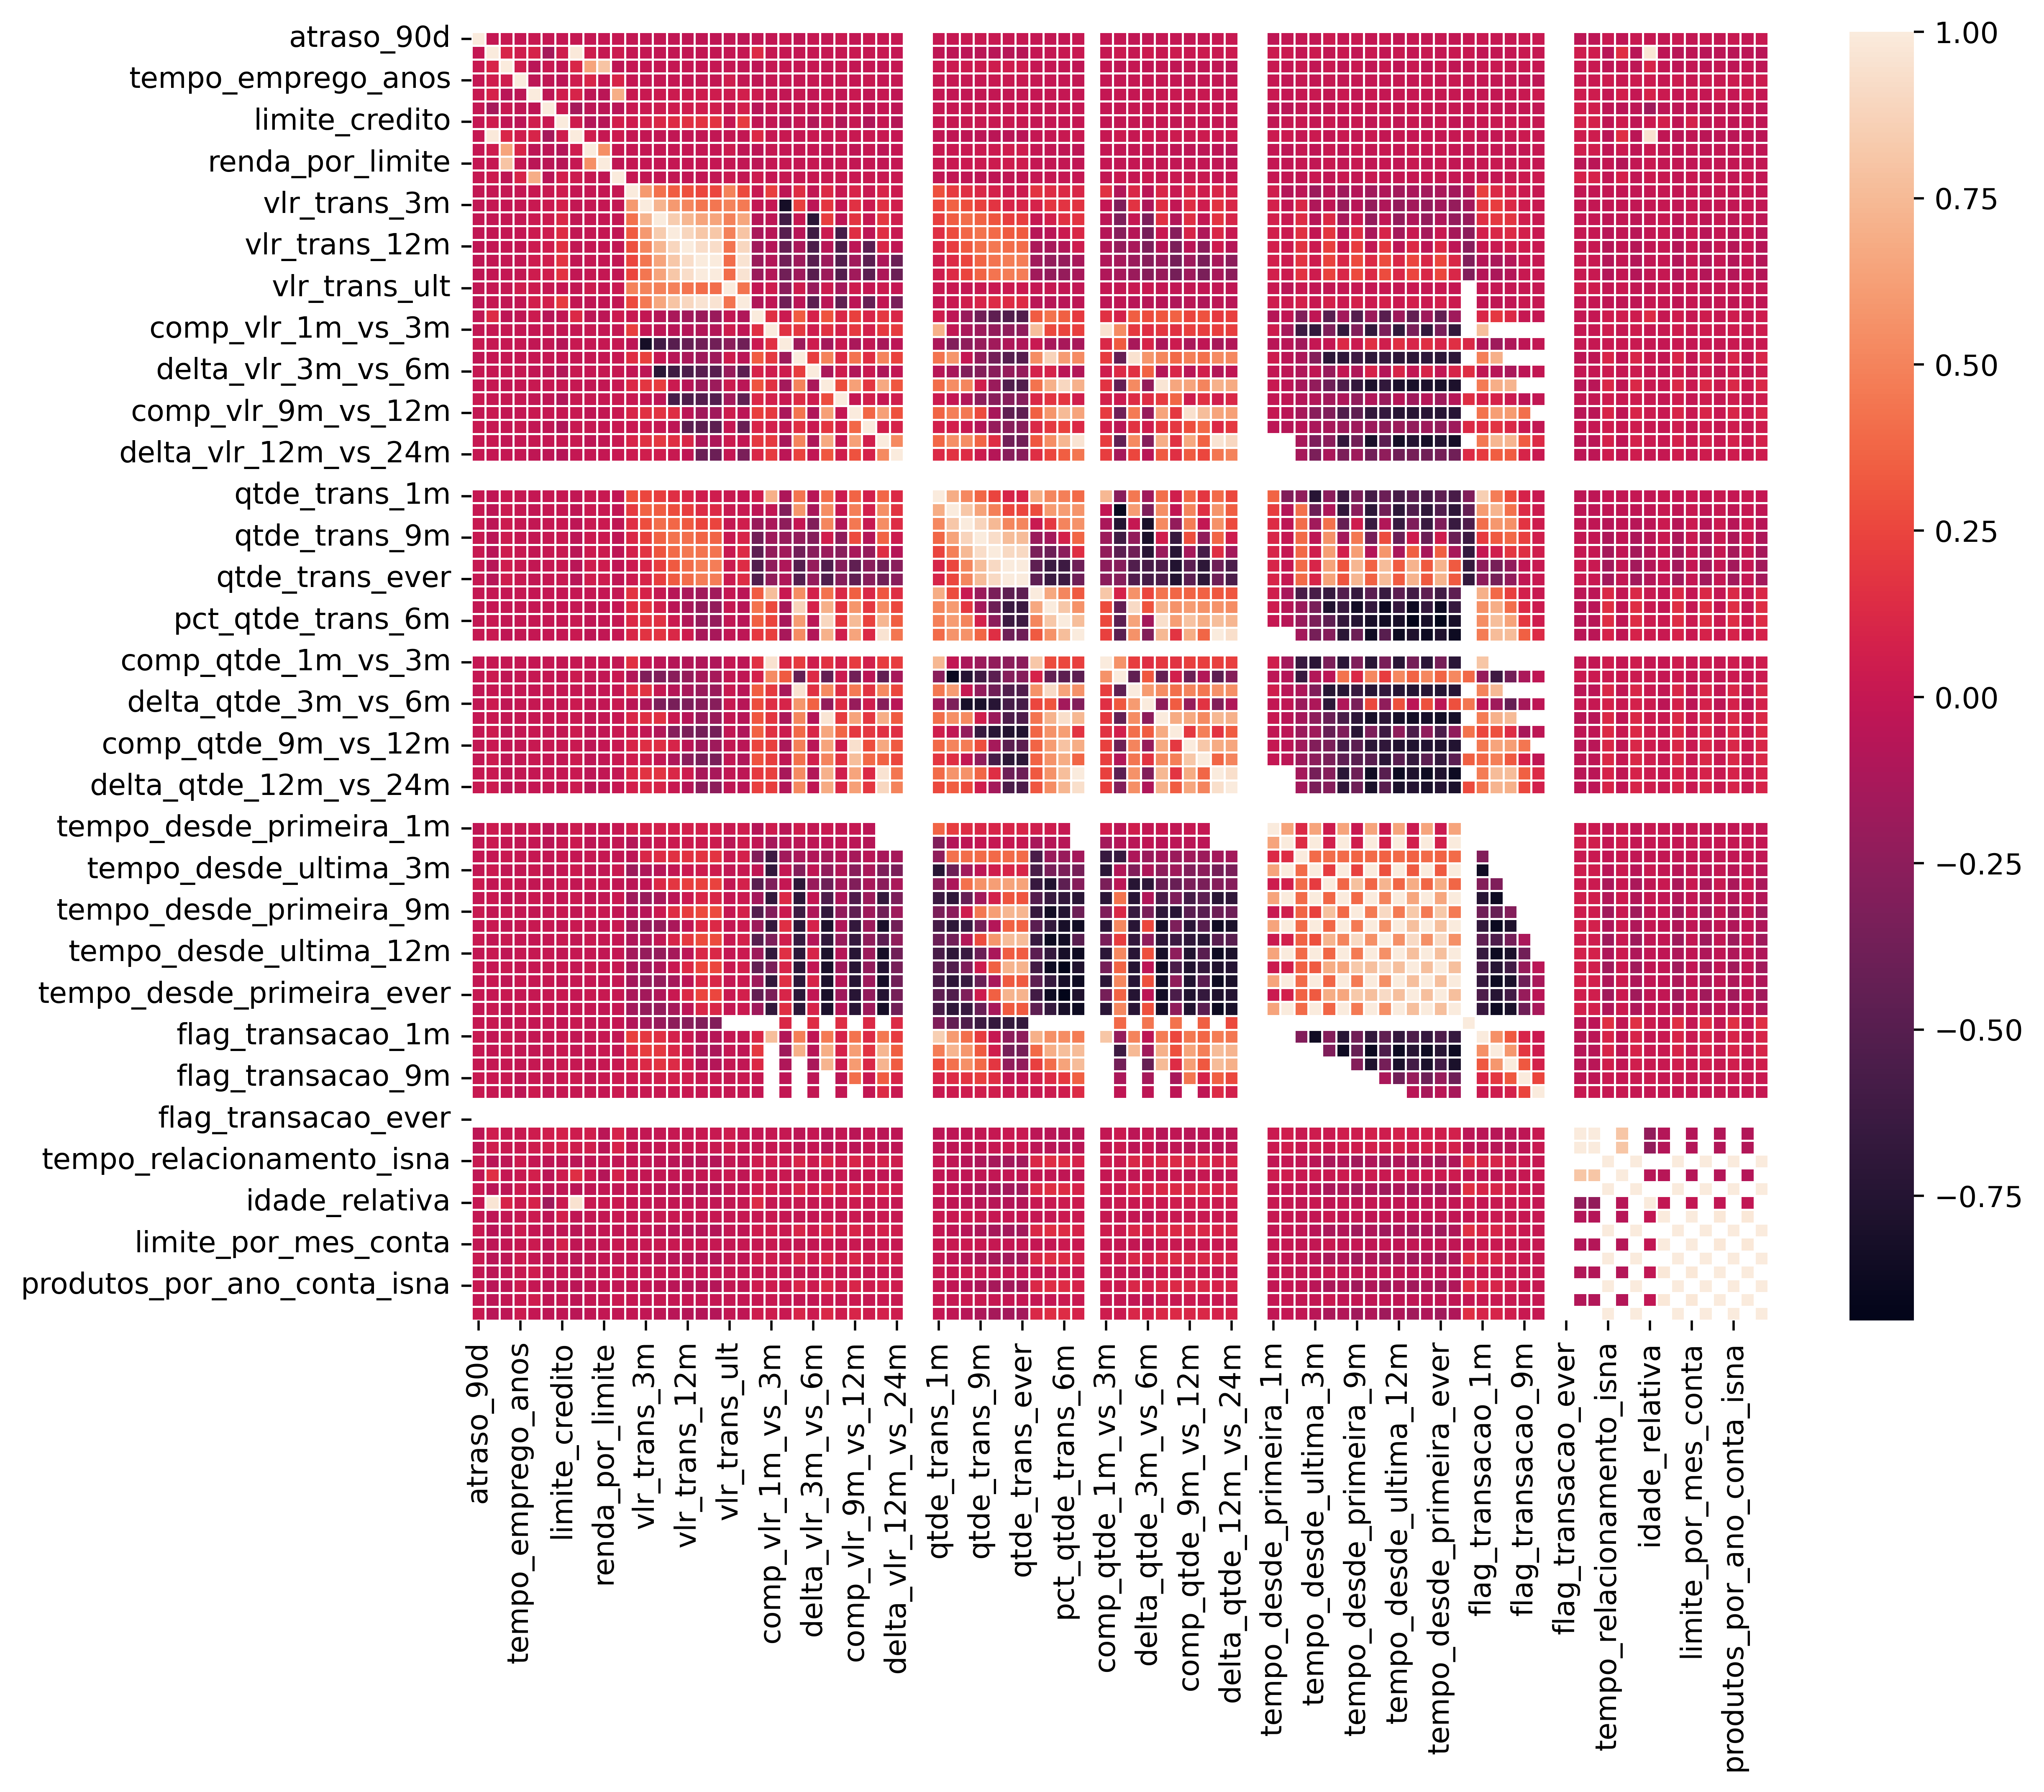

In [108]:
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr,annot=False,fmt=".2f", linewidth=.5)
plt.show()

In [44]:
cols_drop = ['id_cliente', 'data_referencia', 'data_abertura_conta', 'mes_abertura_conta','mes_safra']

remover = remover_vars(abt, iv_threshold=0.000001,corr_threshold=0.8, cols_drop=cols_drop)

In [45]:
len(remover['removidas_corr'])

40

In [46]:
len(remover['final'])

31

In [71]:
col_retirar = cols_drop + ['atraso_90d']
X_TODAS = abt.drop(columns=col_retirar)

X_train_TODAS, X_test_TODAS = model_selection.train_test_split(X_TODAS,
                                                 test_size=0.2,
                                                 random_state=42
)

In [47]:
X = abt[remover['final']]
y = abt['atraso_90d']

In [48]:
(X.shape, len(y))

((4790, 31), 4790)

In [50]:
corr = X.corr(method = 'pearson')
corr

,tempo_desde_primeira_1m,tempo_desde_primeira_3m,vlr_trans_max,tempo_desde_primeira_6m,vlr_trans_min,tempo_emprego_anos,tempo_desde_ultima_12m,vlr_trans_ult,idade_relativa,tempo_desde_primeira_9m,comp_qtde_3m_vs_6m,qtde_trans_12m,renda_por_limite,delta_qtde_6m_vs_9m,delta_vlr_6m_vs_9m,comp_vlr_6m_vs_9m,comp_vlr_1m_vs_3m,log_renda,score_interno,limite_credito,comp_vlr_9m_vs_12m,vlr_trans_6m,delta_vlr_1m_vs_3m,qtde_trans_6m,delta_vlr_9m_vs_12m,vlr_trans_1m,delta_qtde_9m_vs_12m,delta_vlr_12m_vs_24m,delta_vlr_3m_vs_6m,qtde_trans_1m,qtde_produtos
tempo_desde_primeira_1m,1.000000,0.129542,0.050320,0.045856,-0.069923,0.002322,0.650422,0.020623,0.015119,0.019173,0.056104,0.099566,-0.003746,-0.019636,-0.007084,0.016149,0.039470,-0.006058,-0.043950,-0.014964,0.005705,0.069607,-0.057895,0.137917,-0.038303,0.060307,-0.003759,NaN,-0.009906,0.364702,0.016908
tempo_desde_primeira_3m,0.129542,1.000000,0.079717,0.404237,-0.308392,0.006717,0.397161,0.015660,-0.014138,0.370085,-0.108756,0.393338,0.005964,-0.188442,-0.080091,-0.136444,-0.628041,0.006162,-0.006856,0.011796,-0.138350,0.142682,-0.158999,0.403806,-0.058334,-0.037558,-0.182994,-0.140323,-0.094190,-0.235511,0.001302
vlr_trans_max,0.050320,0.079717,1.000000,0.083329,-0.095956,-0.013492,0.027341,0.434526,0.003829,0.084172,-0.055879,0.130598,-0.016328,-0.096112,-0.460422,-0.049428,-0.028343,-0.022255,0.071427,0.212158,-0.041158,0.652979,-0.382732,0.056506,-0.418098,0.269150,-0.090840,-0.336867,-0.470387,-0.000837,0.064244
tempo_desde_primeira_6m,0.045856,0.404237,0.083329,1.000000,-0.487518,0.003070,0.375656,-0.008189,-0.026397,0.782281,-0.734168,0.614131,0.010899,-0.419543,-0.155215,-0.392442,-0.311256,0.008869,-0.006921,0.016970,-0.302142,0.122906,-0.003378,0.421854,-0.128187,-0.048938,-0.337966,-0.123577,-0.199432,-0.252827,-0.012260
vlr_trans_min,-0.069923,-0.308392,-0.095956,-0.487518,1.000000,-0.026428,-0.174007,-0.010299,0.133346,-0.512141,0.348578,-0.464962,-0.037622,0.360063,0.116845,0.304790,0.156863,-0.041778,-0.060297,-0.018873,0.234733,-0.071793,0.026194,-0.203021,0.106142,0.013141,0.302151,0.108389,0.088852,0.049740,0.037418
tempo_emprego_anos,0.002322,0.006717,-0.013492,0.003070,-0.026428,1.000000,0.006472,0.050927,0.038532,-0.002447,-0.002869,0.010545,-0.002713,-0.005503,0.006745,0.000386,-0.002535,0.099827,-0.026656,-0.038233,-0.006467,-0.003430,0.002125,0.006573,0.014756,-0.001367,-0.010657,-0.005507,0.002466,0.004073,-0.038115
tempo_desde_ultima_12m,0.650422,0.397161,0.027341,0.375656,-0.174007,0.006472,1.000000,-0.001714,-0.015014,0.461928,-0.730392,-0.123548,-0.019167,-0.246349,-0.073841,-0.792163,-0.676424,-0.005957,0.005386,-0.020505,-0.726773,-0.216402,0.154503,-0.648361,-0.180876,-0.157252,-0.488833,-0.381473,0.094821,-0.572741,0.007159
vlr_trans_ult,0.020623,0.015660,0.434526,-0.008189,-0.010299,0.050927,-0.001714,1.000000,-0.011186,0.003057,0.008948,0.017316,-0.006441,-0.015875,-0.150379,0.035413,0.044728,0.031847,0.007054,-0.004487,0.045162,0.490520,-0.261088,0.000862,-0.006218,0.497800,-0.019090,-0.006541,-0.206739,0.014390,0.038337
idade_relativa,0.015119,-0.014138,0.003829,-0.026397,0.133346,0.038532,-0.015014,-0.011186,1.000000,-0.027540,0.017170,-0.066590,0.020255,0.049080,0.011255,0.020186,0.007912,0.021813,-0.172962,0.023846,0.032205,-0.008952,0.004338,-0.039899,0.011056,-0.001730,0.053854,0.006330,0.008439,-0.015768,0.089591
tempo_desde_primeira_9m,0.019173,0.370085,0.084172,0.782281,-0.512141,-0.002447,0.461928,0.003057,-0.027540,1.000000,-0.648870,0.620652,0.010259,-0.726716,-0.228970,-0.675692,-0.297406,0.010734,-0.005437,0.013012,-0.458109,0.025559,0.025504,0.049624,-0.175952,-0.080945,-0.488289,-0.178895,-0.103148,-0.331844,-0.009073


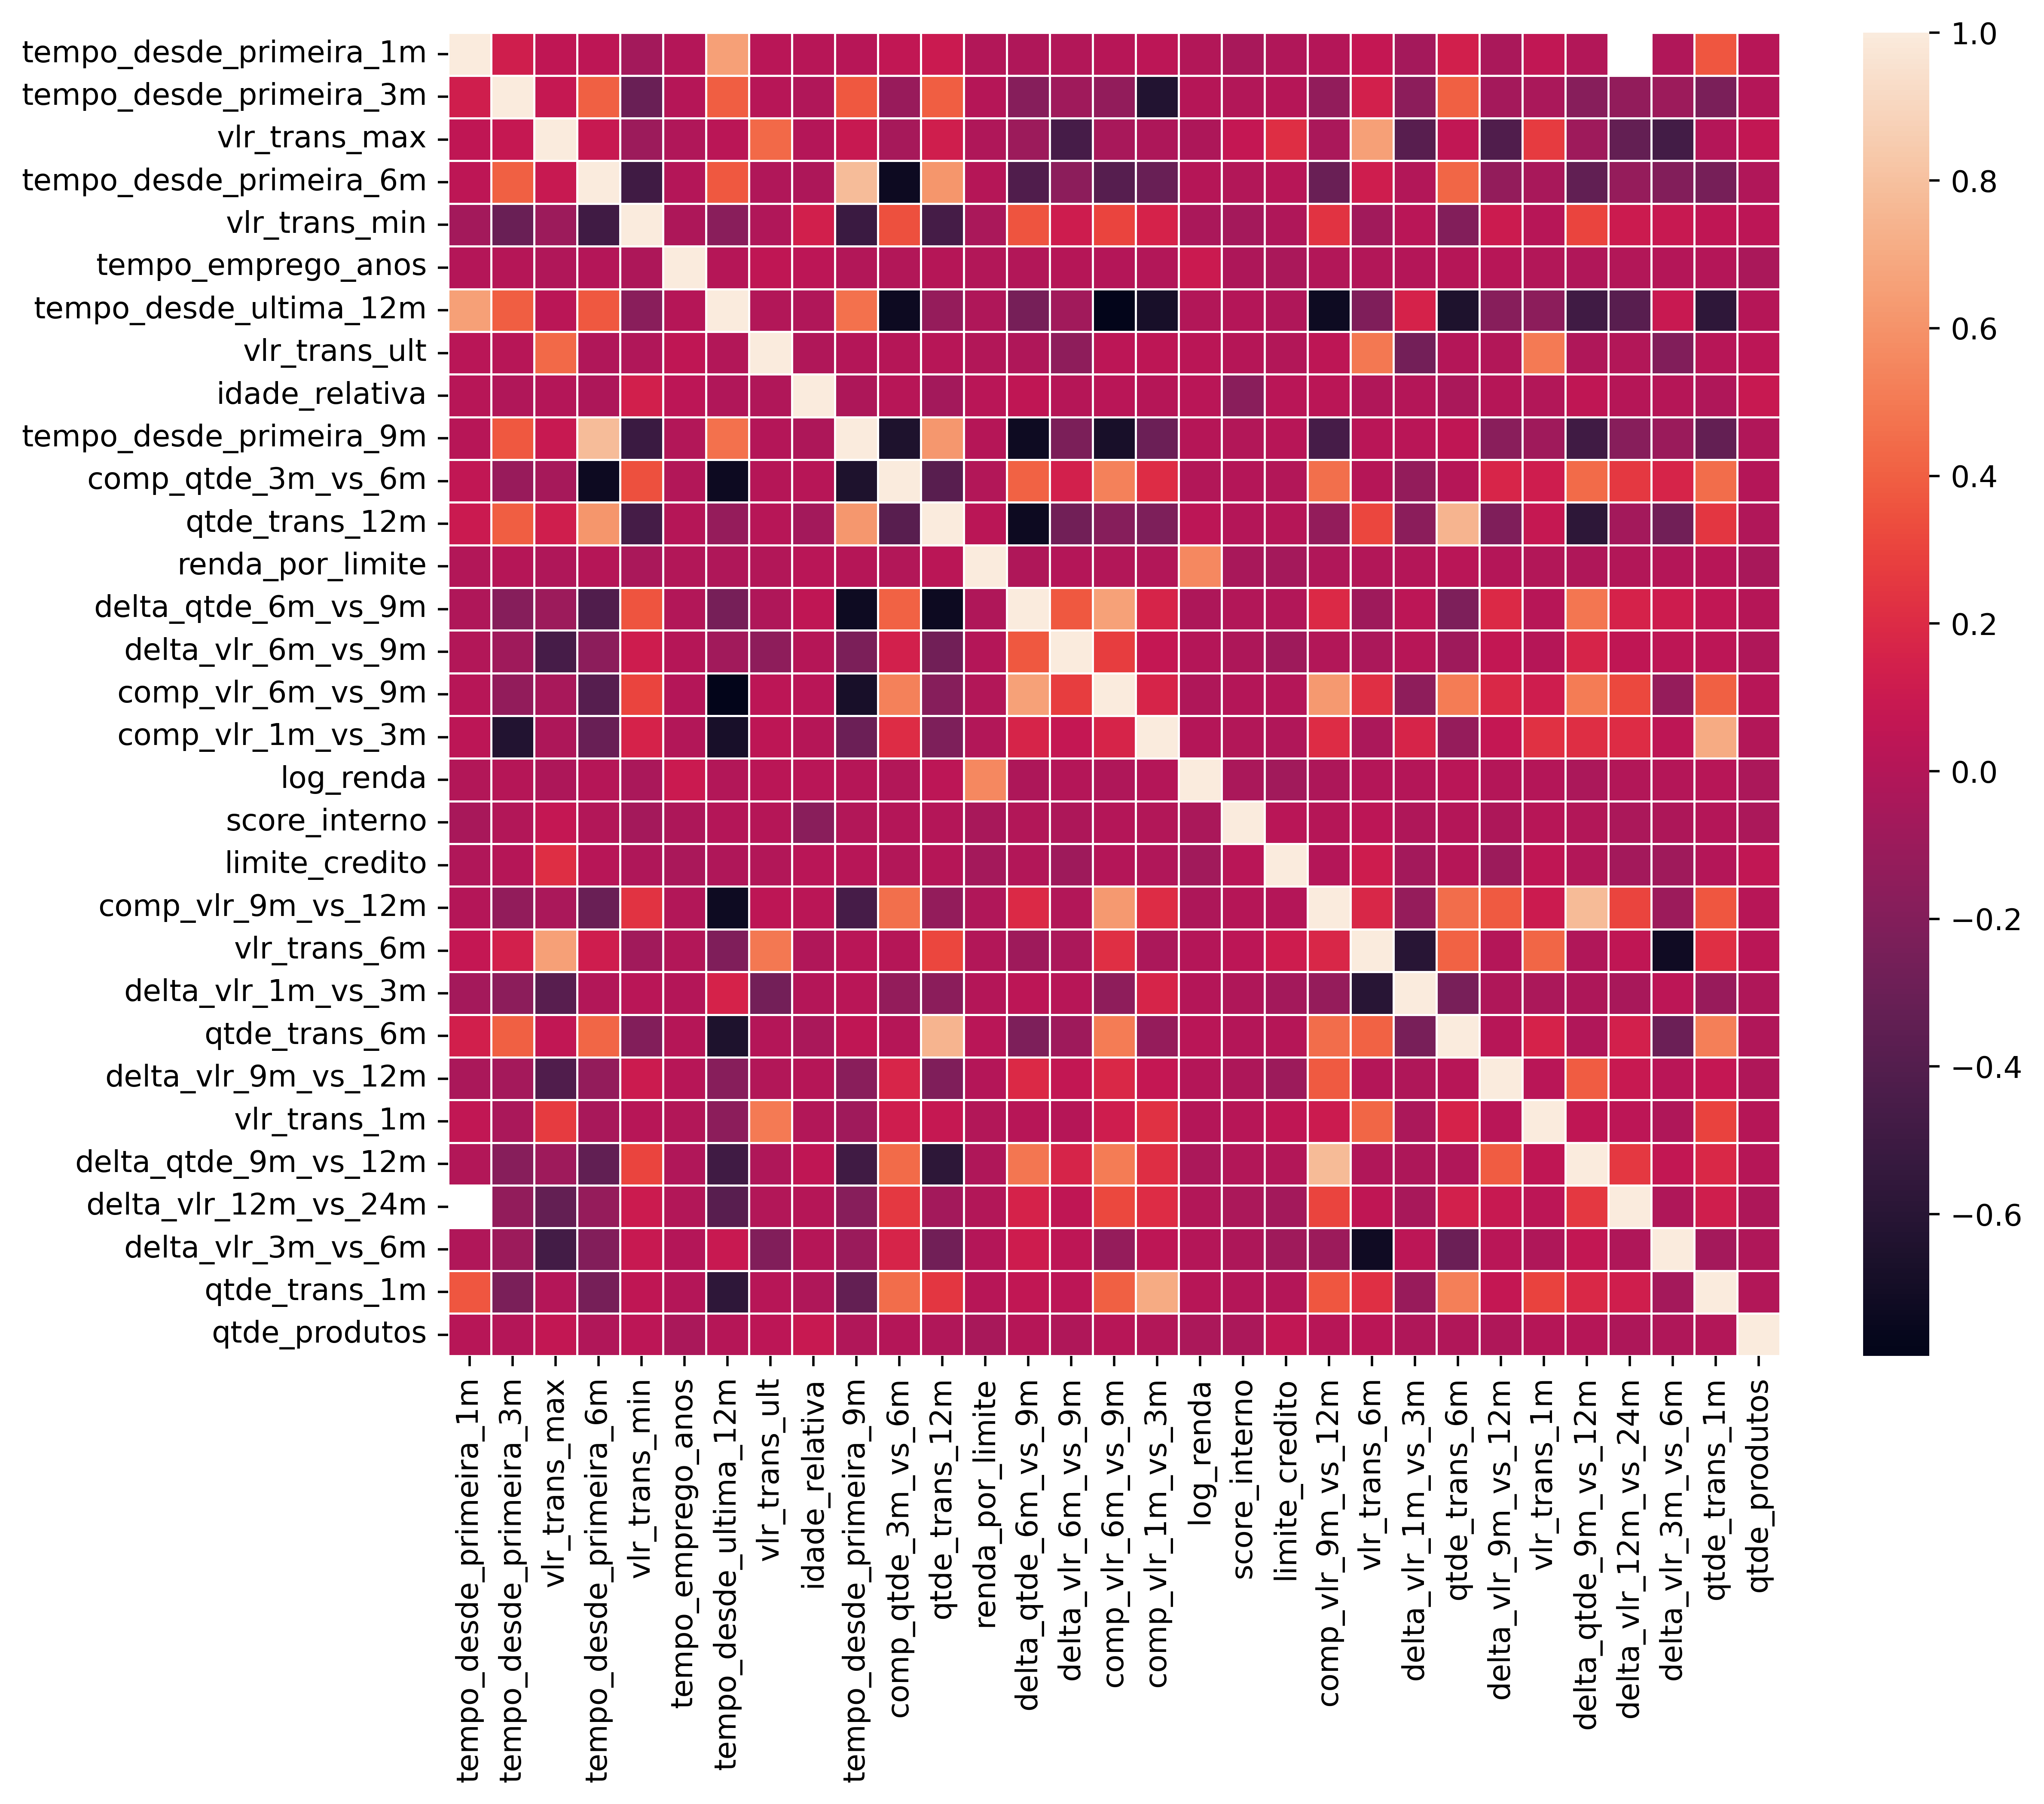

In [51]:
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr,annot=False,fmt=".2f", linewidth=.5)
plt.show()

In [74]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.2,
                                                                    random_state=42)

### 1. DECISION TREE CLASSIFIER

#### TREINO COM COLUNAS PRÉ-SELECIONADAS A PARTIR DA FUNÇÃO REMOVER_VARS()

In [75]:
arvore = tree.DecisionTreeClassifier(random_state=42,
                                     max_depth=5,
                                     min_samples_split=10)

arvore.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


[Text(0.5, 0.8333333333333334, 'qtde_trans_1m <= 3.5\ngini = 0.183\nsamples = 3832\nvalue = [3442, 390]\nclass = 0.0'),
 Text(0.25, 0.5, 'idade_relativa <= 59.68\ngini = 0.181\nsamples = 3812\nvalue = [3429, 383]\nclass = 0.0'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'tempo_emprego_anos <= 4.15\ngini = 0.455\nsamples = 20\nvalue = [13, 7]\nclass = 0.0'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

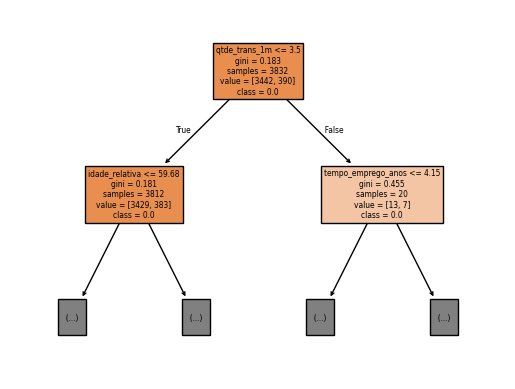

In [76]:
tree.plot_tree(arvore,
               feature_names=X_train.columns,
               max_depth=1,
               filled=True,
               class_names=[str(i) for i in arvore.classes_])

In [77]:
feature_importances= (pd.Series(arvore.feature_importances_,
                                index=X_train.columns)
                           .sort_values(ascending=False)
                           .reset_index()
                           )
feature_importances
feature_importances['acum.'] = feature_importances[0].cumsum()

# %%
best_features = feature_importances[feature_importances['acum.'] < 0.96]

In [78]:
best_features

,index,0,acum.
0,tempo_desde_primeira_9m,0.201862,0.201862
1,idade_relativa,0.177159,0.379021
2,tempo_emprego_anos,0.132826,0.511846
3,delta_vlr_6m_vs_9m,0.107924,0.619771
4,qtde_trans_1m,0.070748,0.690519
5,delta_vlr_3m_vs_6m,0.062805,0.753323
6,tempo_desde_primeira_6m,0.062415,0.815738
7,vlr_trans_ult,0.053728,0.869466
8,limite_credito,0.052718,0.922184


In [79]:
y_train_predict = arvore.predict(X_train[best_features])
y_train_proba = arvore.predict_proba(X_train[best_features])[:, 1]

acc_train = metrics.accuracy_score(y_train, y_train_predict)
auc_train = metrics.roc_auc_score(y_train, y_train_proba)
roc_train = metrics.roc_curve(y_train, y_train_proba)

print("Acurácia treino: ", acc_train)
print("AUC treino: ", auc_train)


y_test_predict = arvore.predict(X_test[best_features])
y_test_proba = arvore.predict_proba(X_test[best_features])[:, 1]

acc_test = metrics.accuracy_score(y_test, y_test_predict)
auc_test = metrics.roc_auc_score(y_test, y_test_proba)
roc_test = metrics.roc_curve(y_test,y_test_proba)
                             
                             
print("Acurácia teste: ", acc_test)
print("AUC teste: ", auc_test)

Acurácia treino:  0.8982254697286013
AUC treino:  0.5
Acurácia teste:  0.9018789144050104
AUC teste:  0.5


c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:392: RuntimeWarning: invalid value encountered in scalar divide
  precision_1 = np.sum((actual == 1) & (preds == 1)) / np.sum(preds == 1)


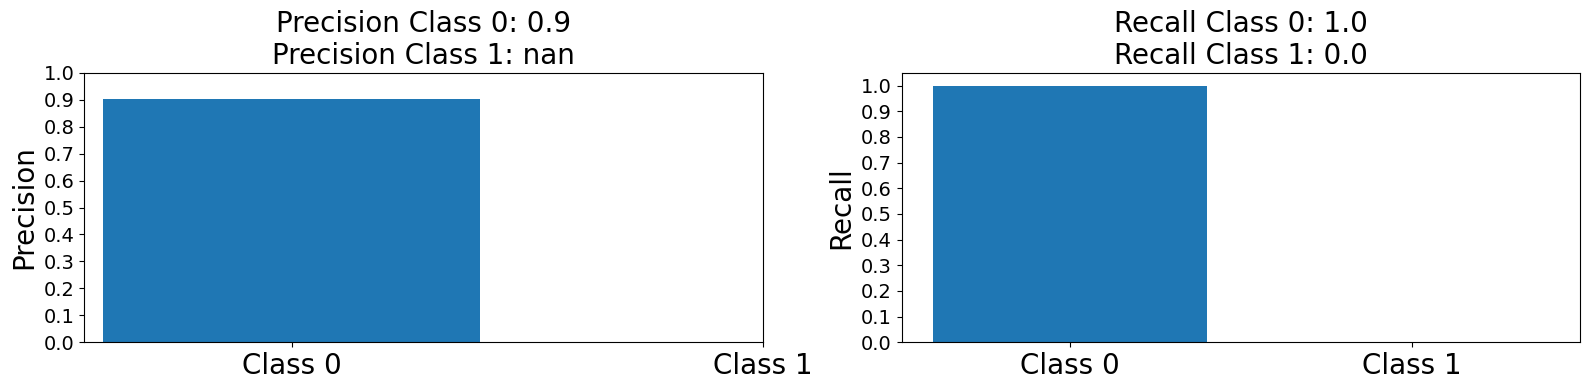

In [80]:
get_precisions_recalls(y_test,y_test_predict)

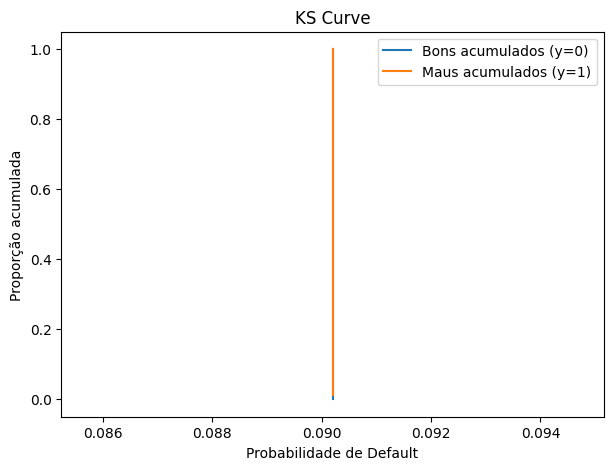

(np.float64(0.1511524822695035), np.float64(0.09019754006708908))

In [81]:
plotar_ks(y_test,y_test_proba)

### 2. CATBOOST


In [82]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np

#### 2.1 TREINO COM TODAS AS COLUNAS QUE NÃO SEJAM ID E DATAS

In [83]:
cat_features = [col for col in X_train_TODAS.columns if X_train_TODAS[col].dtype.name in ["object", "category"]]

cat_features

['estado_civil']

In [84]:
# ===============================
# 1. Identificar variáveis categóricas
# ===============================
cat_features = [col for col in X_train_TODAS.columns if X_train_TODAS[col].dtype.name in ["object", "category"]]

print("Variáveis categóricas:", cat_features)

# ===============================
# 2. Definir modelo base
# ===============================
weight_minority_class = np.sum(y_train == 0) / np.sum(y_train == 1)

catboost = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    class_weights=[1, weight_minority_class],   # penaliza mais a classe 1 (inadimplente), ajuste se precisar
    logging_level='Info'
)

# ===============================
# 3. Espaço de hiperparâmetros
# ===============================
param_dist = {
    "depth": [4, 6, 8, 10],
    "learning_rate": np.linspace(0.01, 0.2, 5),
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "iterations": [200, 400, 600, 800],
    "border_count": [32, 64, 128]
}

# ===============================
# 4. RandomizedSearchCV
# ===============================
random_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_dist,
    n_iter=20,           
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# CatBoost precisa de Pool para saber quais colunas são categóricas
train_pool = Pool(X_train_TODAS, y_train, cat_features=cat_features)

# Ajustar busca
random_search.fit(X_train_TODAS, y_train, cat_features=cat_features)




Variáveis categóricas: ['estado_civil']
Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [40]:
# ===============================
# 5. Avaliar no teste
# ===============================
best_model = random_search.best_estimator_
y_proba_cat = best_model.predict_proba(X_test_TODAS)[:, 1]
y_pred_cat = best_model.predict(X_test_TODAS)

print("Melhores parâmetros:", random_search.best_params_)
print("AUC:", roc_auc_score(y_test, y_proba_cat))
print("F1 :", f1_score(y_test, y_pred_cat))
print("Precisão:", precision_score(y_test, y_pred_cat))
print("Recall:", recall_score(y_test, y_pred_cat))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_cat))

Melhores parâmetros: {'learning_rate': np.float64(0.15250000000000002), 'l2_leaf_reg': 9, 'iterations': 200, 'depth': 10, 'border_count': 32}
AUC: 0.47761524822695034
F1 : 0.10810810810810811
Precisão: 0.10989010989010989
Recall: 0.10638297872340426
Matriz de confusão:
 [[783  81]
 [ 84  10]]


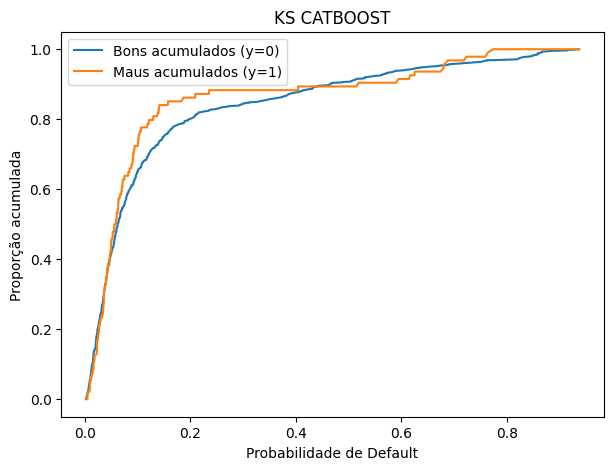

(np.float64(0.1134013002364066), np.float64(0.10691179864014161))

In [41]:
plotar_ks(y_test,y_proba_cat, titulo='KS CATBOOST')

In [42]:
import pandas as pd
feat_imp = pd.DataFrame({
    "feature": X_train_TODAS.columns,
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False)
print(feat_imp.head(20))


                       feature  importance
3           tempo_emprego_anos    5.321718
2                 estado_civil    4.551538
5                score_interno    4.043917
9             renda_por_limite    3.678852
6               limite_credito    3.628089
80  tempo_relacionamento_meses    3.170156
91      produtos_por_mes_conta    3.063652
61     tempo_desde_primeira_6m    3.036176
87        limite_por_mes_conta    2.862441
20               vlr_trans_min    2.815893
1                 renda_mensal    2.633218
18               vlr_trans_ult    2.531955
84              idade_relativa    2.457830
7                       idade2    2.388622
19               vlr_trans_max    2.361514
4                qtde_produtos    2.217042
63     tempo_desde_primeira_9m    1.941403
79   tempo_relacionamento_anos    1.932033
0                        idade    1.877179
59     tempo_desde_primeira_3m    1.849577


#### 2.2 TREINO COM COLUNAS PRÉ-SELECIONADAS A PARTIR DA FUNÇÃO REMOVER_VARS()

In [43]:
# ===============================
# 1. Identificar variáveis categóricas
# ===============================
cat_features = [col for col in X_train.columns if X_train[col].dtype.name in ["object", "category"]]

print("Variáveis categóricas:", cat_features)

# ===============================
# 2. Definir modelo base
# ===============================
weight_minority_class = np.sum(y_train == 0) / np.sum(y_train == 1)

catboost = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    class_weights=[1, weight_minority_class],   # penaliza mais a classe 1 (inadimplente), ajuste se precisar
    logging_level="Silent"
)

# ===============================
# 3. Espaço de hiperparâmetros
# ===============================
param_dist = {
    "depth": [4, 6, 8, 10],
    "learning_rate": np.linspace(0.01, 0.2, 10),
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "iterations": [200, 400, 600, 800],
    "border_count": [32, 64, 128]
}

# ===============================
# 4. RandomizedSearchCV
# ===============================
random_search2 = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_dist,
    n_iter=20,              # nº de combinações testadas (ajuste se quiser mais)
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# CatBoost precisa de Pool para saber quais colunas são categóricas
train_pool = Pool(X_train, y_train, cat_features=cat_features)

# Ajustar busca
random_search2.fit(X_train, y_train, cat_features=cat_features)




Variáveis categóricas: []
Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,<catboost.cor...0029F589F87A0>
,param_distributions,"{'border_count': [32, 64, ...], 'depth': [4, 6, ...], 'iterations': [200, 400, ...], 'l2_leaf_reg': [1, 3, ...], ...}"
,n_iter,20
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [44]:
# ===============================
# 5. Avaliar no teste
# ===============================
best_model2 = random_search2.best_estimator_
y_proba_cat2 = best_model2.predict_proba(X_test)[:, 1]
y_pred_cat2 = best_model2.predict(X_test)

print("Melhores parâmetros:", random_search.best_params_)
print("AUC:", roc_auc_score(y_test, y_proba_cat2))
print("F1 :", f1_score(y_test, y_pred_cat2))
print("Precisão:", precision_score(y_test, y_pred_cat2))
print("Recall:", recall_score(y_test, y_pred_cat2))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_cat2))

Melhores parâmetros: {'learning_rate': np.float64(0.15250000000000002), 'l2_leaf_reg': 9, 'iterations': 200, 'depth': 10, 'border_count': 32}
AUC: 0.4911101260835302
F1 : 0.0782122905027933
Precisão: 0.08235294117647059
Recall: 0.07446808510638298
Matriz de confusão:
 [[786  78]
 [ 87   7]]


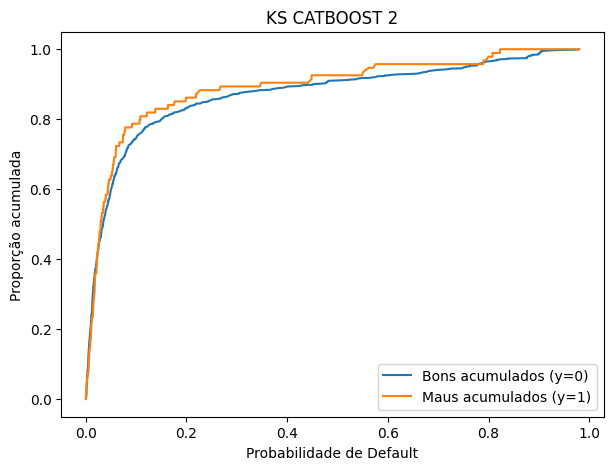

(np.float64(0.07641351457840828), np.float64(0.06004730187952709))

In [45]:
plotar_ks(y_test,y_proba_cat2, titulo='KS CATBOOST 2')

## COMO ARRUMAR?

#### Proposta 1 - UPWEIGHT THE MINORITY CLASS

In [46]:
weight_minority_class = np.sum(y_train == 0) / np.sum(y_train == 1)

weight_minority_class

np.float64(8.825641025641026)

In [47]:
arvore2 = tree.DecisionTreeClassifier(class_weight={0:1, 1:weight_minority_class}, random_state=42)
arvore2.fit(X_train, y_train)
preds = arvore2.predict(X_test)

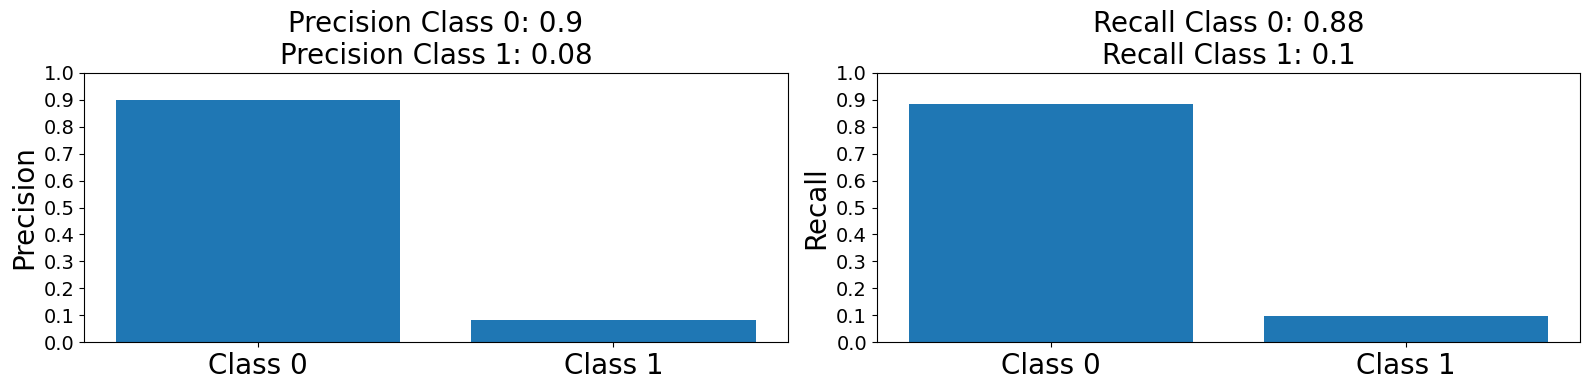

In [48]:
get_precisions_recalls(y_test, preds)

In [49]:
y_train_predict2 = arvore2.predict(X_train)
y_train_proba2 = arvore2.predict_proba(X_train)[:, 1]

acc_train2 = metrics.accuracy_score(y_train, y_train_predict2)
auc_train2 = metrics.roc_auc_score(y_train, y_train_proba2)
roc_train2 = metrics.roc_curve(y_train, y_train_proba2)

print("Acurácia treino: ", acc_train2)
print("AUC treino: ", auc_train2)

y_test_predict2 = arvore2.predict(X_test)
y_test_proba2 = arvore2.predict_proba(X_test)[:, 1]

acc_test2 = metrics.accuracy_score(y_test, y_test_predict2)
auc_test2 = metrics.roc_auc_score(y_test, y_test_proba2)
roc_test2 = metrics.roc_curve(y_test,y_test_proba2)
                             
                             
print("Acurácia teste: ", acc_test2)
print("AUC teste: ", auc_test2)

Acurácia treino:  0.9924321503131524
AUC treino:  0.991637613790432
Acurácia teste:  0.8058455114822547
AUC teste:  0.48910313238770686


#### Proposta 2 - Oversample Minority Class

In [50]:
#get indices of each class
indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]
indices = np.concatenate([indices_0, indices_1])

#get weights for each class
weights = np.empty(indices_0.shape[0] + indices_1.shape[0])
weights[:indices_0.shape[0]] = 1
weights[indices_0.shape[0]:] = weight_minority_class
weights = weights/np.sum(weights)

#sample new indices
sampled_indices = np.random.choice(indices, indices.shape[0], p=weights)

In [51]:
# construir datasets oversampled
X_train_oversampled = X_train.iloc[sampled_indices]
labels_train_oversampled = y_train.iloc[sampled_indices]


In [52]:
print('Fraction of positive labels in oversampled data:', str(round(100*np.mean(labels_train_oversampled),3)) + '%')

Fraction of positive labels in oversampled data: 50.235%


In [53]:
arvore3 = tree.DecisionTreeClassifier(random_state=42,
                                  max_depth=5,
                                  min_samples_split=10)

arvore3.fit(X_train_oversampled, labels_train_oversampled)
preds = arvore3.predict(X_test)

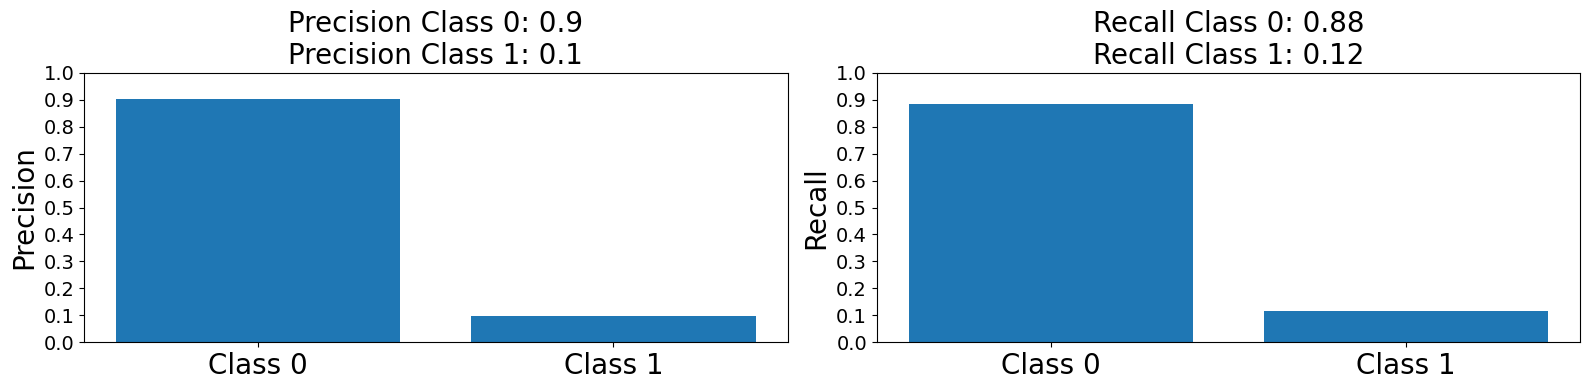

In [54]:
get_precisions_recalls(y_test, preds)

In [55]:
y_train_predict3 = arvore3.predict(X_train_oversampled)
y_train_proba3 = arvore3.predict_proba(X_train_oversampled)[:, 1]

acc_train3 = metrics.accuracy_score(labels_train_oversampled, y_train_predict3)
auc_train3 = metrics.roc_auc_score(labels_train_oversampled, y_train_proba3)
roc_train3 = metrics.roc_curve(labels_train_oversampled, y_train_proba3)

print("Acurácia treino: ", acc_train3)
print("AUC treino: ", auc_train3)

y_test_predict3 = arvore3.predict(X_test)
y_test_proba3 = arvore3.predict_proba(X_test)[:, 1]

acc_test3 = metrics.accuracy_score(y_test, y_test_predict3)
auc_test3 = metrics.roc_auc_score(y_test, y_test_proba3)
roc_test3 = metrics.roc_curve(y_test,y_test_proba3)
                           
print("Acurácia teste: ", acc_test3)
print("AUC teste: ", auc_test3)



Acurácia treino:  0.5589770354906054
AUC treino:  0.6017307391088199
Acurácia teste:  0.8079331941544885
AUC teste:  0.5110938731284476
